# Digit Recognizer Project
## Step 3. Choosing a Model

In this notebook I will test the effectiveness of three separate models: linear regression, k-nearest neighbor, and random forest. 

### 1. Load and prepare data

The MNIST data was converted into compressed files with CSV format in a previous workbook. To begin, I will load the files into pandas dataframes and sample a smaller dataset to reduce computation time. I will then apply **VarianceThreshold** from scikit-learn to reduce dimensionality of the features followed by **StandardScalar** to help improve the performance of the models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

train_image_file = './data/mnist_train_images.gz'
train_label_file = './data/mnist_train_labels.gz'
test_image_file = './data/mnist_test_images.gz'
test_label_file = './data/mnist_test_labels.gz'

# Read compressed CSV files into pandas dfs 
x_train = pd.read_csv(train_image_file, index_col = 0, compression = 'gzip')
y_train = pd.read_csv(train_label_file, index_col = 0, compression = 'gzip')
X_test = pd.read_csv(test_image_file, index_col = 0, compression = 'gzip')
Y_test = pd.read_csv(test_label_file, index_col = 0, compression = 'gzip')

# Sample a subset of images (10000 train and 1000 test)
y_sample = y_train.sample(n=10000)
Y_sample = Y_test.sample(n=1000)
x_sample = x_train.iloc[y_sample.index.tolist()]
X_sample = X_test.iloc[Y_sample.index.tolist()]

# Remove low variance features (be sure to only fit on train set to avoid leakage)
selector = VarianceThreshold(threshold = 0.25)
x_low = selector.fit_transform(x_sample)
X_low = selector.transform(X_sample)

# Normalize features (be sure to only fit on train set to avoid leakage)
scaler = StandardScaler()
x = scaler.fit_transform(x_low)
X = scaler.transform(X_low)

# Convert target variables to 1d array
y = y_sample['label'].values
Y = Y_sample['label'].values

In [2]:
x.shape

(10000, 659)

In [3]:
X.shape

(1000, 659)

### 2. Fit and evaluate logistic regression model

Multinomial logistic regression can be used to build a model where there are more than two outcomes that are not ordered. The algorithm works by estimating probabilities for a given outcome based on the dependent variables using a logistic function.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lm = LogisticRegression(C=20, solver='lbfgs', multi_class='multinomial')
lm.fit(x,y)
Y_lm = lm.predict(X)
print "Pred", Y_lm[:30]
print "True", Y[:30]

Pred [1 3 7 7 6 0 1 5 7 0 7 0 0 3 8 9 8 8 7 1 4 7 0 6 7 2 5 3 1 9]
True [1 3 7 7 6 0 1 5 7 0 7 0 2 5 8 9 8 5 7 2 4 7 8 5 7 6 5 3 1 9]


In [10]:
print accuracy_score(Y, Y_lm)

0.873


The accuracy of the logistic model is decent with about 87% of the images in the test set classified correctly.

### 3. Fit and evaluate k-nearest neighbors model

The k-nearest neighbors classifier computes the distance between feature vectors for each observation and then classifies the observations by grouping them with their nearest neighbors. The parameter k determines how many neighbors to consider when assigning a class to an observation. 

The value of k can be tuned by using a combination of iteration over a range of possible k values and K-fold cross validation. For each k value, the train data is divided into K folds of equal size (typically 10 are used), and the model is then fit K times with each fold acting once as the test set in order to score the accuracy of the model for that value of k. (Don't confuse the parameters k and K).

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
k_value = []
accuracy = []
for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
    k_value.append(k)
    accuracy.append(scores.mean())

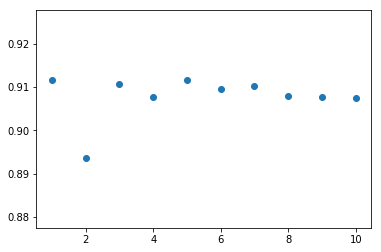

In [5]:
plt.scatter(k_value, accuracy)
plt.show()

In [6]:
print accuracy

[0.9116005051845472, 0.8935950765129279, 0.9108007012081043, 0.9076051909263396, 0.911504616131476, 0.9094938131343057, 0.9103018909881818, 0.9079976837233339, 0.9077989846534953, 0.9075025731101931]


This analysis suggests that the accuracy score is relatively stable for odd values of k between 1 and 5. After k=5, accuracy begins to decline. The following model will use k=5.

In [7]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x,y)
Y_knn = knn.predict(X)
print "Pred", Y_knn[:30]
print "True", Y[:30]

Pred [1 3 7 7 6 0 1 5 7 0 7 0 2 3 8 9 8 5 7 2 4 7 8 5 7 6 5 3 1 9]
True [1 3 7 7 6 0 1 5 7 0 7 0 2 5 8 9 8 5 7 2 4 7 8 5 7 6 5 3 1 9]


In [11]:
print accuracy_score(Y, Y_knn)

0.907


The accuracy of the k-nn model is slightly better than the logistic regression, with over 90% of the images in the test set classified correctly.

### 4. Fit and evaluate random forest model

A random forest classifier is an ensemble method that creates multiple decision trees and then classifies based on the average outcome of the individual trees. This model has several parameters to be tuned, so I will use the **GridSearchCV** method from scikit-learn to optimize the best combination of parameters when fitting the model. 

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(oob_score = True, random_state=0)
param_grid = { 
    'n_estimators': [50, 100, 500],
    'max_depth': [10,25, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x,y)

print CV_rfc.best_params_

{'max_features': 'log2', 'n_estimators': 500, 'max_depth': 50}


In [25]:
Y_rfc = CV_rfc.predict(X)
print "Pred", Y_rfc[:30]
print "True", Y[:30]

Pred [1 3 7 7 6 0 1 5 7 0 7 0 6 3 8 9 8 6 7 2 4 7 8 5 7 6 5 3 1 9]
True [1 3 7 7 6 0 1 5 7 0 7 0 2 5 8 9 8 5 7 2 4 7 8 5 7 6 5 3 1 9]


In [26]:
print accuracy_score(Y, Y_rfc)

0.946


The random forest model is even better than the k-nn, with almost 95% of the images in the test set classified correctly.